In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  71041      0 --:--:-- --:--:-- --:--:-- 71041
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
     |████████████████████████████████| 61kB 2.8MB/s 
Uninstalling torch-1.6.0+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.6.0+cu101
Uninstalling torchvision-0.7.0+cu101:
  Successfully uninstalled torchvision-0.7.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...
- [1 files][110.9 MiB/110.9 MiB]                                                
Operation completed over 1 objects/110.9 MiB.                                    
Copying gs://

In [2]:
!pip install -q efficientnet_pytorch       # Convolutional Neural Net from Google Research
!pip install git+https://github.com/abhishekkrthakur/wtfml #Abishek Takur's Library

  Cloning https://github.com/abhishekkrthakur/wtfml to /tmp/pip-req-build-9xkne4am
  Running command git clone -q https://github.com/abhishekkrthakur/wtfml /tmp/pip-req-build-9xkne4am
  Created wheel for wtfml: filename=wtfml-0.0.4-cp36-none-any.whl size=12538 sha256=8db1c44af07e7e877a2dda9fdd3a5fb9d1968247656bca0e58b03d97a8f448e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-uftkgvud/wheels/a5/67/ee/67208960d01000b054678b0bff5e5f91995651fe354abbc989
Successfully built wtfml


In [3]:
import os

# Get the API Key JSON file from Kaggle Account Settings
os.environ['KAGGLE_USERNAME'] = "XXXXXX" 
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

In [4]:
!mkdir input

In [5]:
! kaggle datasets download -d nroman/melanoma-external-malignant-256 

100% 2.88G/2.88G [00:30<00:00, 65.6MB/s]
100% 2.88G/2.88G [00:31<00:00, 99.6MB/s]
 99% 1.00G/1.01G [00:15<00:00, 44.6MB/s]
100% 1.01G/1.01G [00:15<00:00, 70.1MB/s]


In [6]:
!unzip -q melanoma-efficientnet-inference.zip 
!unzip -q melanoma-external-malignant-256.zip

In [7]:
!rm -rf *.pth *.zip *.whl

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


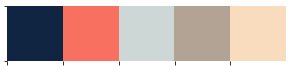

In [8]:
#Sys
import cv2
import os
from PIL import Image 
import gc
import time
import datetime as dt
import random
from tqdm.notebook import tqdm

#Data Tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Validate Images

#Sci-kit learn tools
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

#PyTorch 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import LongTensor, FloatTensor
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim.lr_scheduler as ReduceLROnPlateau
from wtfml.utils import EarlyStopping #Abishek's Library



import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
#TPU Stuffs
try:
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    _xla_available = True
except ImportError:
    _xla_available = False

try:
    from apex import amp

    _apex_available = True
except ImportError:
    _apex_available = False


#Augmentations
from albumentations import (ToFloat, Normalize, HorizontalFlip, Compose, Resize, ShiftScaleRotate,
                          VerticalFlip, RandomBrightnessContrast, RandomContrast, HueSaturationValue, Blur, GaussNoise, Rotate, Cutout)
from albumentations.pytorch import ToTensor

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

import warnings
warnings.filterwarnings('ignore')

color_palette = ['#102542', '#f87060', '#cdd7d6', '#b3a394', '#f9dbbd']
sns.palplot(sns.color_palette(color_palette))

sns.set_style('darkgrid')
sns.despine(left=True, bottom=True)


In [9]:
def set_seed(seed = 7237):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [10]:
train_df = pd.read_csv('./data/train_processed.csv')
test_df = pd.read_csv('./data/test_processed.csv')


to_drop = ['path_dicom', 'path_jpeg', 'diagnosis']

for drop in to_drop:
    if drop in train_df.columns:
        train_df.drop([drop], axis=1, inplace=True)

roman_train = pd.read_csv('train_concat.csv') #Roman's Processed Data

roman_train['patient_id'] = roman_train['patient_id'].fillna(0)


to_encode = ['sex', 'anatom_site_general_challenge']
encoded_all = []

roman_train[to_encode[0]] = roman_train[to_encode[0]].astype(str)
roman_train[to_encode[1]] = roman_train[to_encode[1]].astype(str)

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(roman_train[column])
    encoded_all.append(encoded)

roman_train[to_encode[0]] = encoded_all[0]
roman_train[to_encode[1]] = encoded_all[1]

col_list = list(train_df.columns)
col_list.remove('benign_malignant')
roman_train.columns = col_list


common_images = train_df['dcm_name'].unique()
new_data = roman_train[~roman_train['dcm_name'].isin(common_images)]

train_df = pd.concat([train_df, new_data], axis=0)


for drop in to_drop:
    if drop in test_df.columns:
        test_df.drop([drop], axis=1, inplace=True)
    
path_train = './train/train/'
path_test = './test/test/'

train_df['path_jpg'] = path_train + train_df['dcm_name']+'.jpg'
test_df['path_jpg'] = path_test + test_df['dcm_name'] + '.jpg'

train_df['age'] = train_df['age'].fillna(-1)

normalized_train = preprocessing.normalize(train_df[['sex', 'age', 'anatomy']])
normalized_test = preprocessing.normalize(test_df[['sex', 'age', 'anatomy']])

train_df['sex'] = normalized_train[:, 0]
train_df['age'] = normalized_train[:, 1]
train_df['anatomy'] = normalized_train[:, 2]

test_df['sex'] = normalized_test[:, 0]
test_df['age'] = normalized_test[:, 1]
test_df['anatomy'] = normalized_test[:, 2]

print(f'Train Len: {len(train_df)} \nTest_Len:{len(test_df)}')

Train Len: 37648 
Test_Len:10982


In [11]:
vertical_flip = 0.5
horizontal_flip = 0.5

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

columns = ['sex', 'age', 'anatomy']
no_columns = 3 
output_size = 1 

In [12]:
np.array(train_df.iloc[0][columns].values, dtype=np.float32)

array([0.02221674, 0.9997532 , 0.        ], dtype=float32)

In [13]:
class MelanomaDataset(Dataset):
    
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True, is_valid=False, is_test=False):
        self.dataframe, self.is_train, self.is_valid= dataframe, is_train, is_valid
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        
        if is_train or is_test :
            self.transform = Compose([Normalize(mean = (0.485, 0.456, 0.406),
                                                std = (0.229, 0.224, 0.225), 
                                                max_pixel_value=255.0, 
                                                always_apply=True),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      HueSaturationValue(
                                          sat_shift_limit=[0.7, 1.3], 
                                          hue_shift_limit=[-0.1, 0.1]),
                                      RandomBrightnessContrast(brightness_limit=[0.7, 1.3],
                                                               contrast_limit= [0.7, 1.3]),
                                      ToTensor()])
        else:
            self.transform = Compose([Normalize(mean = (0.485, 0.456, 0.406), 
                                                std = (0.229, 0.224, 0.225), 
                                                max_pixel_value=255.0,
                                                always_apply=True), 
                                      ToTensor()])
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        image_path = self.dataframe['path_jpg'][index]
        image = cv2.imread(image_path)
        
        csv_data = np.array(self.dataframe.iloc[index][['sex', 'age', 'anatomy']].values, dtype=np.float32)
        
        image = self.transform(image=image)
        
        image = image['image']
        
        if self.is_train or self.is_valid:
            return (image, csv_data), self.dataframe['target'][index]
        else:
            return(image, csv_data)

In [14]:
class CustomLoader:
    def __init__(self, dataframe, is_train = True, is_valid = False, is_test = False):
        """
        :param image_paths: list of paths to images
        :param targets: numpy array
        :param resize: tuple or None
        :param augmentations: albumentations augmentations
        """
        self.dataframe = dataframe
        if is_train:
            self.dataset = MelanomaDataset(self.dataframe, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=True, is_valid=False, is_test=False)

        elif is_valid:
            self.dataset = MelanomaDataset(self.dataframe, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=False, is_valid=True, is_test=False)
        elif is_test:
            self.dataset = MelanomaDataset(self.dataframe, vertical_flip = vertical_flip, horizontal_flip=horizontal_flip,
                                          is_train=False, is_valid=False, is_test=True)


    def fetch(self, batch_size, num_workers, drop_last=False, shuffle=True, tpu=False):
        """
        :param batch_size: batch size
        :param num_workers: number of processes to use
        :param drop_last: drop the last batch?
        :param shuffle: True/False
        :param tpu: True/False, to use tpu or not
        """
        sampler = None
        if tpu:
            sampler = torch.utils.data.distributed.DistributedSampler(
                self.dataset,
                num_replicas=xm.xrt_world_size(),
                rank=xm.get_ordinal(),
                shuffle=shuffle,
            )

        data_loader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=batch_size,
            sampler=sampler,
            drop_last=drop_last,
            num_workers=num_workers,
        )
        return data_loader

In [15]:
class EfficientModel(nn.Module):
    def __init__(self, output_size, no_columns, net_type='b2'):
        super().__init__()
        self.net_type, self.no_columns = net_type, no_columns
        
        if net_type not in ['b2', 'b4', 'b7']:
            raise Exception('Sorry, it is an unsupported EfficientNet Type. Only b2, b4, b7 are valid.')
        
        self.features = EfficientNet.from_pretrained('efficientnet-'+net_type)
        
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                nn.BatchNorm1d(250),
                                nn.ReLU(),
                                nn.Dropout(p=0.2),
                                nn.Linear(250, 250),
                                nn.BatchNorm1d(250),
                                nn.ReLU(),
                                nn.Dropout(p=0.2))
        if net_type=='b4':
            self.classification = nn.Sequential(nn.Linear(1792+250, output_size))
        elif net_type == 'b2':
            self.classification = nn.Sequential(nn.Linear(1408+250, output_size))
        elif net_type == 'b7':
            self.classification = nn.Sequential(nn.Linear(2560+250, output_size))
        
    def forward(self, input_data, prints=False):
        (image, csv_data) = input_data
        if prints:print('Input Image Shape:', image.shape, '\n' + 
                       'Input csv_data shape:', csv_data.shape)
        
        image = self.features.extract_features(image)
        
        if prints:print('Feature Image Shape:', image.shape)
            
        if self.net_type=='b4': image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1792)
        elif self.net_type=='b2': image= F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        else: image = F.avg_pool2d(image, image.size()[2:].reshape(-1, 2560))
            
        if prints: print('Image Reshaped Shape:', image.shape)
        
        csv_data = self.csv(csv_data)
        
        if prints: print('CSV Data:', csv_data.shape)
            
        image_csv_data = torch.cat((image, csv_data), dim=1)
        
        out = self.classification(image_csv_data)
        
        if prints: print('Out Shape:', out.shape)
        
        return out

In [16]:
train_df.head()

,dcm_name,ID,sex,age,anatomy,benign_malignant,target,path_jpg
0,ISIC_2637011,IP_7279968,0.022217,0.999753,0.000000,benign,0,./train/train/ISIC_2637011.jpg
1,ISIC_0015719,IP_3075186,0.000000,0.993884,0.110432,benign,0,./train/train/ISIC_0015719.jpg
2,ISIC_0052212,IP_2842074,0.000000,0.999800,0.019996,benign,0,./train/train/ISIC_0052212.jpg
3,ISIC_0068279,IP_6890425,0.000000,1.000000,0.000000,benign,0,./train/train/ISIC_0068279.jpg
4,ISIC_0074268,IP_8723313,0.000000,0.995893,0.090536,benign,0,./train/train/ISIC_0074268.jpg


In [17]:
eff_model = EfficientModel(output_size = output_size, no_columns = no_columns, net_type='b2')


sample_loader = CustomLoader(train_df, is_train=True, is_test=False, is_valid=False).fetch(batch_size=3, num_workers=8)


tk0 = tqdm(sample_loader, total=len(sample_loader))

for data in sample_loader:
    data_example = data[0]
    labels_example = torch.tensor(data[1], dtype=torch.float32)
    break

print('Data Shape:', data_example[0].shape,'| \n', data_example[1])
print('Label:', labels_example)


out = eff_model(data_example, prints=True)

criterion_sample = nn.BCEWithLogitsLoss()

loss = criterion_sample(out, labels_example.unsqueeze(1))

print('Loss:', loss.item())

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


Data Shape: torch.Size([3, 3, 256, 256]) | 
 tensor([[0.0222, 0.9998, 0.0000],
        [0.0000, 0.9939, 0.1104],
        [0.0000, 0.9998, 0.0200]])
Label: tensor([0., 0., 0.])
Input Image Shape: torch.Size([3, 3, 256, 256]) 
Input csv_data shape: torch.Size([3, 3])
Feature Image Shape: torch.Size([3, 1408, 8, 8])
Image Reshaped Shape: torch.Size([3, 1408])
CSV Data: torch.Size([3, 250])
Out Shape: torch.Size([3, 1])
Loss: 0.7744547724723816


In [18]:
device = torch.device('cpu')

In [19]:
train_len = len(train_df)
test_len = len(test_df)

oof = np.zeros(shape=(train_len, 1))

preds_submission = torch.zeros(size = (test_len,1 ), dtype=torch.float32, device = device)

print('oof shape:', oof.shape, '\n' + 
     'prediction shape:', preds_submission.shape)

oof shape: (37648, 1) 
prediction shape: torch.Size([10982, 1])


In [20]:
epochs = 10
patience = 3
TTA = 3
num_workers = 8
learning_rate = 0.0005
weight_decay = 0.0
lr_patience = 1

lr_factor = 0.4

batch_size1 = 16
batch_size2 = 8

version = 'v3'

In [21]:
from tqdm import tqdm

try:
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    _xla_available = True
except ImportError:
    _xla_available = False

try:
    from apex import amp

    _apex_available = True
except ImportError:
    _apex_available = False
    


def reduce_fn(vals):
    return sum(vals) / len(vals)

In [22]:
class AverageMeter:
    """ 
        Computes and stores the average
    """
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [24]:
class Engine:
    
    def __init__(self, model, optimizer, device, scheduler=None, print_step=None, use_tpu=False, fp16=False, print_metrics = 10):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler
        self.print_step = None
        self.use_tpu = use_tpu
        self.fp16 = fp16
        self.accumulation_steps = 1
        self.data_loader = None
        self.print_metrics = print_metrics
        if self.use_tpu and not _xla_available:
            raise Exception(
                "pytorch_xla is not installed"
            )
        if self.fp16 and not _apex_available:
            raise Exception("fp16 needs Apex. Apex is not installed")
        if self.fp16 and use_tpu:
            raise Exception("Apex fp16 is not available when using TPUs")
        if self.fp16:
            self.accumulation_steps = 1
  
    def train(self, data_loader):
        self.data_loader = data_loader
        losses = AverageMeter() # We need to use Average Loss from all the losses computed in TPU Cores
        predictions = []
        
        self.model.train() #Initializing Model with Training Mode
        
        if self.accumulation_steps > 1:
            optimizer.zero_grad()
        if self.use_tpu:
            para_loader = pl.ParallelLoader(self.data_loader, [self.device])
            tloader = para_loader.per_device_loader(self.device) # TQDM Loader to monitor progress
        else:
            tloader = tqdm(self.data_loader, total= len(self.data_loader))
        
        for b_idx, data in enumerate(tloader):
            
            inputs = data[0]
            
            inputs = (inputs[0].to(self.device), inputs[1].to(self.device))
            labels = data[1].to(self.device)
            
            if self.accumulation_steps == 1 and b_idx==0:
                self.optimizer.zero_grad()
            
            out = self.model(inputs)
            
            loss = nn.BCEWithLogitsLoss()(out, labels.view(-1, 1).type_as(out))
            
            if not self.use_tpu:
                with torch.set_grad_enabled(True):
                    if fp16:
                        with amp.scale_loss(loss, optimizer) as scaled_loss:
                            scaled_loss.backward()
                    else:
                        loss.backward()
                    if (b_idx + 1) % self.accumulation_steps == 0:
                        self.optimizer.step()
                        if scheduler is not None:
                            self.scheduler.step(loss)
                        if b_idx > 0:
                            self.optimizer.zero_grad()
            else:
                loss.backward()
                xm.optimizer_step(self.optimizer)
                if self.scheduler is not None:
                    self.scheduler.step(loss)
                if b_idx > 0:
                    self.optimizer.zero_grad()
            if self.use_tpu:
                reduced_loss = xm.mesh_reduce('loss_reduce', loss, reduce_fn)
                losses.update(reduced_loss.item(), self.data_loader.batch_size)
            else:
                losses.update(loss.item(),self.data_loader.batch_size)
            
            if not self.use_tpu:
                tloader.set_postfix(loss=losses.avg)
            # else:
            #     # if b_idx % self.print_metrics == 0 or b_idx == len(self.data_loader):
            #     #     xm.master_print(
            #     #         f"{dt.datetime.now()}: Batch {b_idx} / {len(data_loader)}, loss={losses.avg}"
            #     #     )
        if not self.use_tpu:
            tloader.close()
        return losses.avg
    
    
    def evaluate(self, data_loader):
        self.data_loader = data_loader
        losses = AverageMeter()
        
        final_predictions = []
        final_targets = []
        self.model.eval()
        
        with torch.no_grad():
            if self.use_tpu:
                para_loader = pl.ParallelLoader(self.data_loader, [self.device])
                tloader = para_loader.per_device_loader(self.device)
                              
            else:
                tloader = tqdm(self.dataloader, total=len(self.data_loader))
            
            for b_idx, data in enumerate(tloader):
                
                inputs = data[0]
                labels = data[1].to(self.device)
                
                inputs = (inputs[0].to(self.device), inputs[1]. to(self.device))
                
                out = self.model(inputs)
                
                loss = nn.BCEWithLogitsLoss()(out, labels.view(-1, 1).type_as(out))
                
                if self.use_tpu:
                    reduced_loss = xm.mesh_reduce('loss_reduce', loss, reduce_fn)
                    losses.update(reduced_loss.item(), data_loader.batch_size)
                    # if b_idx % self.print_metrics == 0 or b_idx == len(data_loader):
                    #     xm.master_print(
                    #         f"{dt.datetime.now()}: Batch {b_idx} / {len(data_loader)}, loss={losses.avg}")
                else:
                    losses.update(loss.item(), data_loader.batch_size)
                    tloader.set_postfix(loss=losses.avg)
                
                
            if not self.use_tpu:
                tloader.close()
                
            return losses.avg

In [25]:
model_eff = EfficientModel(output_size = output_size, no_columns = no_columns, net_type='b2')

Loaded pretrained weights for efficientnet-b2


In [26]:
k = 3

group_fold = GroupKFold(n_splits = k)

folds = group_fold.split(X= np.zeros(train_len),
                        y = train_df['target'],
                        groups= train_df['ID'].tolist())

In [27]:
def train_model(model, epochs=15):
    
    device = xm.xla_device()
    
    model = model.to(device)
    
    for fold, (train_indices, valid_indices) in enumerate(folds):
        
        xm.master_print('-'*10, f'Fold{fold}', '-'*10)
    
        train_data = train_df.iloc[train_indices].reset_index(drop=True)
        valid_data = train_df.iloc[valid_indices].reset_index(drop=True)
        
        
        train_loader = CustomLoader(train_data,
                                    is_train=True,
                                    is_valid=False,
                                    is_test=False
                                   ).fetch(batch_size=batch_size1,
                                           drop_last=True,
                                           tpu=True,
                                           num_workers = 8,
                                           shuffle=True      
                                    )
        valid_loader = CustomLoader(valid_data,
                                   is_train=False,
                                   is_valid=True,
                                   is_test=False
                                   ).fetch(batch_size=batch_size2,
                                          num_workers=4,
                                          shuffle=False,
                                          drop_last=False,
                                          tpu=True)
        
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=lr_patience, verbose=True, factor=lr_factor)
        
        es = EarlyStopping(patience=3, mode='min', tpu=True)
        
        eng = Engine(model, optimizer, device, scheduler=None, print_step=None, use_tpu=True, fp16=False)
        
        for epoch in range(epochs):
            train_loss = eng.train(data_loader = train_loader)
            valid_loss = eng.evaluate(data_loader = valid_loader)
            
            xm.master_print(f"Epoch ={epoch}| Train Loss = {train_loss} | Valid Loss={valid_loss}")
            scheduler.step(valid_loss)
            
            es(valid_loss, model, model_path=f'model_fold_{fold}.bin')
            if es.early_stop:
                xm.master_print('Early Stopping')
                break
            gc.collect()

In [28]:
def _mp_fn(rank, flags):
    torch.set_default_tensor_type('torch.FloatTensor')
    a = train_model(model_eff, epochs = 10)

In [ ]:
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

---------- Fold0 ----------
Epoch =0| Train Loss = 0.253914315671641 | Valid Loss=0.1566062332745547
Validation score improved (inf --> 0.1566062332745547). Saving model!
Epoch =1| Train Loss = 0.21442217493847926 | Valid Loss=0.2533067571765124
EarlyStopping counter: 1 out of 3
